# Policy Control - DAAF: Regret

In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all episodes at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Thus regret is $\frac{G^{m}_{avg,K_{max}} - G^{FR}_{avg,K_{max}}}{|G^{FR}_{avg,K_{max}}|}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:
  - OP/OT - options policy operating on an options trajectory - i.e. parent trajectory, where the option start matches the reward window period, and the end matchs as well
  - PP/IMR - primitive actions policy, where missing rewards are replaced with a zero (Impute Missing Rewards)
  - PP/LSQ - primitive actions policy, where rewards are recovered; before recovery, the behavior is the same as PP/IMR
  - PP/nTD-SU - primitive actions policy, on n-step TD, where only $t-nstep$ gets updated, considering $t$ is a step with observed aggregate feedback

In [1]:
import copy
import importlib
import os
import pathlib
from typing import Any, Mapping, Sequence

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import ray
import scipy
import seaborn as sns
import tensorflow as tf
from daaf import estimator_metrics
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import proportion

2024-06-10 15:12:22,457	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-10 15:12:23.810339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 15:12:23.885054: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 15:12:23.887077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 15:12:25.457982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from utils import dataproc

In [4]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/daaf/exp/controljob/agg/1710783127/1711123071/metrics/*.parquet")

In [5]:
df_metrics = dataproc.read_data(files)

2024-06-10 15:12:26,713	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/datasource/parquet_datasource.py:242: FutureWarning: Passing 'use_legacy_dataset' is deprecated as of pyarrow 15.0.0 and will be removed in a future version.
  pq_ds = pq.ParquetDataset(


[dataset]: Run `pip install tqdm` to enable progress reporting.


2024-06-10 15:12:30,518	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
/home/guilherme/.pyenv/versions/3.9.16/envs/rl_daaf_py39/lib/python3.9/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)


In [6]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,630,1710783127-1d9505bc-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-25.917591125198097, -25.242472266244057, -27...","{'returns': {'mean': -26.38985736925515, 'std'...",PP/DMR
1,630,1710783127-1d89640b-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-36.30110935023772, -36.318541996830426, -36....","{'returns': {'mean': -35.62290015847861, 'std'...",PP/IMR
2,630,1710783127-1db0e303-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-34.00475435816165, -33.67194928684628, -34.0...","{'returns': {'mean': -34.005071315372426, 'std...",PP/LEAST
3,630,1710783127-1d5db710-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-33.450079239302696, -33.543581616481774, -33...","{'returns': {'mean': -33.55023771790809, 'std'...",PP/LEAST
4,630,1710783127-1d1a31c8-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-33.47226624405705, -33.75594294770206, -33.5...","{'returns': {'mean': -33.58858954041204, 'std'...",PP/LEAST
...,...,...,...,...,...,...
315995,1470,1710783127-fe6a0699-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-14.731475186947655, -15.038069340584636, -15...","{'returns': {'mean': -15.277090414683892, 'std...",PP/IMR
315996,1470,1710783127-fe6094fc-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-126.26444595513256, -124.39836845683209, -12...","{'returns': {'mean': -125.84687287559481, 'std...",PP/IMR
315997,1470,1710783127-fec7d9c9-RedGreenSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-10.719918422841605, -9.496261046906866, -9.8...","{'returns': {'mean': -9.940516655336506, 'std'...",PP/LEAST
315998,1470,1710783127-fe818bf8-ABCSeq,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[-19.54180829367777, -19.250849762066622, -18....","{'returns': {'mean': -19.194017675050983, 'std...",PP/IMR


In [7]:
df_metrics.iloc[0]["meta"]

{'algorithm': 'q-learning',
 'algorithm_args': '{}',
 'discount_factor': 1.0,
 'drop_truncated_feedback_episodes': False,
 'dyna_prog_state_values': array([-38.24046866, -36.59401423, -36.54157405, -35.77078702,
        -35.88692312,   0.        , -33.25992091,   0.        ,
        -34.42030072, -32.37397904, -30.49810961,   0.        ,
          0.        , -29.57750584, -21.35853848,   0.        ]),
 'env': {'args': '{"map_name": "4x4"}',
  'level': '4x4',
  'name': 'IceWorld',
  '_level': '4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64JMEBETNDXFFPYWTQJF46S5BJ4NXXCHNMJSLII3ROYXI76DFOC3VAABGNVA='},
 'epsilon': 0.2,
 'exp_id': '1710783127-1d9505bc-IceWorld',
 'learning_rate': 0.1,
 'policy_type': 'PP',
 'reward_period': 4,
 'run_id': 12,
 'traj_mapping_method': 'DMR'}

In [8]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,630,1710783127-1d9505bc-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-25.917591125198097, -25.242472266244057, -27...","{'returns': {'mean': -26.38985736925515, 'std'...",PP/DMR
1,630,1710783127-1d89640b-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-36.30110935023772, -36.318541996830426, -36....","{'returns': {'mean': -35.62290015847861, 'std'...",PP/IMR
2,630,1710783127-1db0e303-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-34.00475435816165, -33.67194928684628, -34.0...","{'returns': {'mean': -34.005071315372426, 'std...",PP/LEAST
3,630,1710783127-1d5db710-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-33.450079239302696, -33.543581616481774, -33...","{'returns': {'mean': -33.55023771790809, 'std'...",PP/LEAST
4,630,1710783127-1d1a31c8-IceWorld,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-33.47226624405705, -33.75594294770206, -33.5...","{'returns': {'mean': -33.58858954041204, 'std'...",PP/LEAST
...,...,...,...,...,...,...
315995,1470,1710783127-fe6a0699-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-14.731475186947655, -15.038069340584636, -15...","{'returns': {'mean': -15.277090414683892, 'std...",PP/IMR
315996,1470,1710783127-fe6094fc-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-126.26444595513256, -124.39836845683209, -12...","{'returns': {'mean': -125.84687287559481, 'std...",PP/IMR
315997,1470,1710783127-fec7d9c9-RedGreenSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-10.719918422841605, -9.496261046906866, -9.8...","{'returns': {'mean': -9.940516655336506, 'std'...",PP/LEAST
315998,1470,1710783127-fe818bf8-ABCSeq,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[-19.54180829367777, -19.250849762066622, -18....","{'returns': {'mean': -19.194017675050983, 'std...",PP/IMR


In [9]:
envs = dataproc.get_distinct_envs(df_metrics)

In [10]:
envs

{('IceWorld', '4x4'): '{"map_name": "4x4"}',
 ('ABCSeq', 'n=7'): '{"length": 7, "distance_penalty": false}',
 ('FrozenLake-v1', '4x4'): '{"is_slippery": false, "map_name": "4x4"}',
 ('ABCSeq', 'n=10'): '{"length": 10, "distance_penalty": false}',
 ('TowerOfHanoi', 'disks=4'): '{"num_disks": 4}',
 ('RedGreenSeq',
  'n=9'): '{"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}',
 ('GridWorld',
  '4x12'): '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}',
 ('IceWorld', '8x8'): '{"map_name": "8x8"}'}

## Comparison: Regret - relative to full rewards observation

In [11]:
def calculate_regret_over_configurations(
    df_data, episode: int
):    
    df_result = copy.deepcopy(df_data[df_data["episode"] == episode])
    for key in ("algorithm", "algorithm_args", "reward_period", "discount_factor"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta[key])    
    for key in ("level", "name"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["env"][key])

    # (env/level)  x (algorithm/algorithm_args) x reward period -> which method is the winner
    df_result["env"] =  df_result["name"] + "/" + df_result["level"]
    del df_result["meta"]    
    del df_result["name"]
    del df_result["level"]
    del df_result["exp_id"]
    
    algo_types = {
        "one-step": set(["sarsa", "q-learning"]),
        "n-step": set(["nstep-sarsa"]),
    }
    def calc_regret(y_pred, y_oracle):
        # agg returns
        mean_y_oracle = np.mean(y_oracle)
        return (np.mean(y_pred) - mean_y_oracle) / np.abs(mean_y_oracle)

    dfs = {} 
    for algo_type, algorithms in algo_types.items():
        df_algo = df_result[df_result["algorithm"].apply(lambda met: met in algorithms)]
        methods = sorted(df_algo["method"].unique())
        rows = []
        keys = ["env", "algorithm", "algorithm_args", "discount_factor", "reward_period"]
        df_baseline = df_algo[df_algo["reward_period"] == 1]
        baselines = {}
        for row in df_baseline.to_dict("records"):
            key = tuple(row[key] for key in keys[:-1])
            baselines[key] = row["returns"]

        df_rp = df_algo[df_algo["reward_period"] != 1]
        rows = []
        for row in df_rp.to_dict("records"):
            key = tuple([row[key] for key in keys[:-1]])
            full_reward_mean_return = baselines[key]
            regret = calc_regret(y_pred=row["returns"], y_oracle = full_reward_mean_return)
            row["relative_regret"] = regret
            row["method"] = row["method"]
            rows.append(row)

        df_regret = pd.DataFrame(rows)
        df_regret = df_regret[["env", "method", "reward_period", "relative_regret"]].sort_values(
            ["env", "method", "reward_period"]
        )
        # drop frozen-lake
        df_regret = df_regret[df_regret["env"].apply(lambda name: "Frozen" not in name)]
        assert np.sum(np.sum(pd.isnull(df_regret))) == 0
        dfs[algo_type] = df_regret
    return dfs

In [12]:
PALETTES = {
    key: color for key, color in zip(sorted(df_metrics["method"].unique()), sns.color_palette())
}

In [13]:
PALETTES

{'OP/OT': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'PP/DMR': (1.0, 0.4980392156862745, 0.054901960784313725),
 'PP/FR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'PP/IMR': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'PP/LEAST': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'PP/nTD-SU': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)}

In [14]:
def plot_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = copy.deepcopy(df_data[["env", "reward_period", "method", "relative_regret"]])
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]    
    rps = sorted(df_raw["reward_period"].unique())
    fig, axes = plt.subplots(
        nrows=1, ncols=len(rps), figsize=(4 * len(rps), 4), 
        sharey=False,
    )
    
    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["reward_period"] == rp]
        sns.boxplot(
            df_plot, 
            x="env", y="relative_regret", 
            hue="method",
            palette=PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Period, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Relative regret (returns ratio)")
            ax.legend(loc='upper center', bbox_to_anchor=(len(rps) / 2.0, 1.3), ncol=len(rps), fancybox=True)
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"        
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight") 

In [15]:
dfs_regret = calculate_regret_over_configurations(df_metrics, episode=df_metrics["episode"].max())

### One-Step

In [16]:
dfs_regret["one-step"]

,env,method,reward_period,relative_regret
121,ABCSeq/n=10,OP/OT,2,-1.239644
151,ABCSeq/n=10,OP/OT,2,-1.246518
416,ABCSeq/n=10,OP/OT,2,-1.288183
463,ABCSeq/n=10,OP/OT,2,-1.291939
189,ABCSeq/n=10,OP/OT,4,-5.872881
...,...,...,...,...
570,TowerOfHanoi/disks=4,PP/LEAST,8,-0.097249
65,TowerOfHanoi/disks=4,PP/LEAST,16,-0.353553
164,TowerOfHanoi/disks=4,PP/LEAST,16,-0.354237
315,TowerOfHanoi/disks=4,PP/LEAST,16,-0.270651


In [17]:
dfs_regret["one-step"].dtypes

env                 object
method              object
reward_period        int64
relative_regret    float64
dtype: object

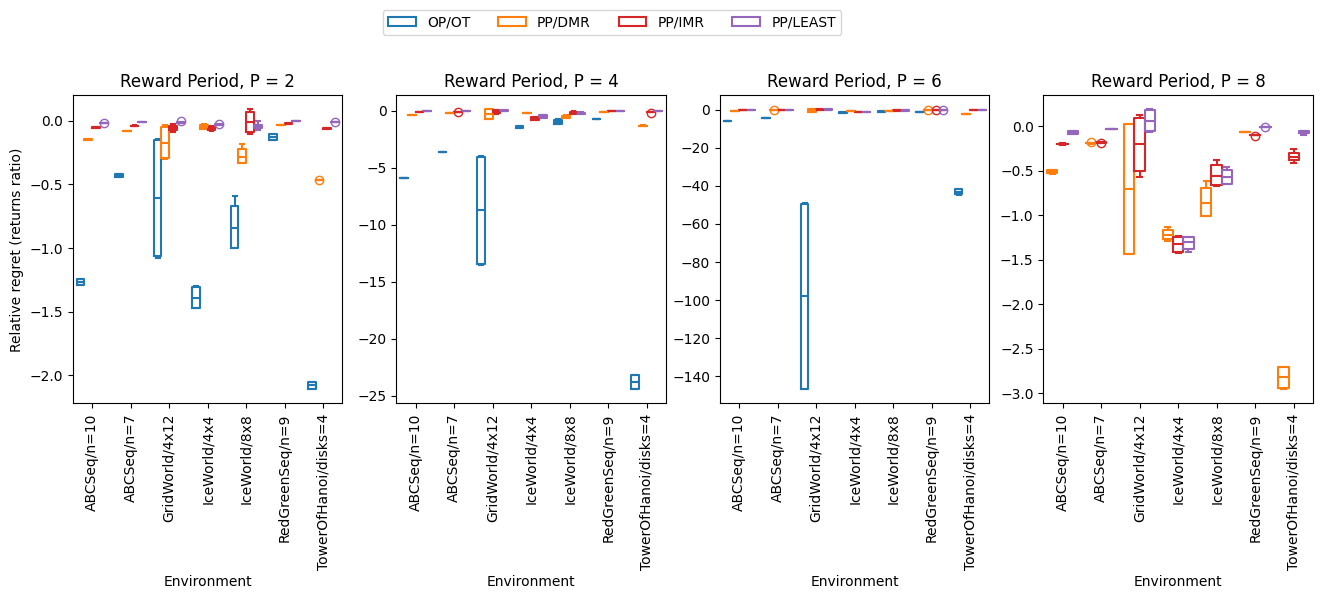

In [18]:
plot_regret(dfs_regret["one-step"][dfs_regret["one-step"]["reward_period"] < 16], suffix="one-step_all")

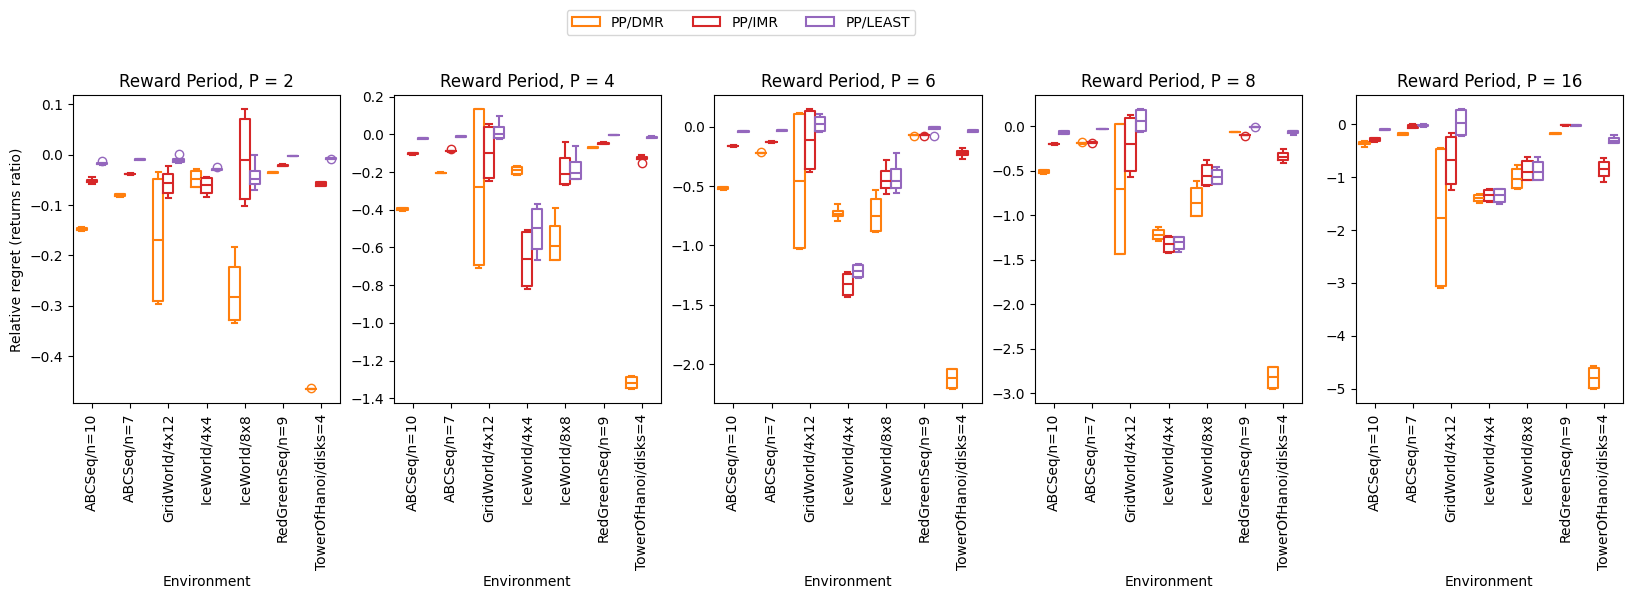

In [19]:
plot_regret(dfs_regret["one-step"], method_filter_fn=lambda x: "OP/OT" not in x, suffix="one-step_nooptions")

### N-step

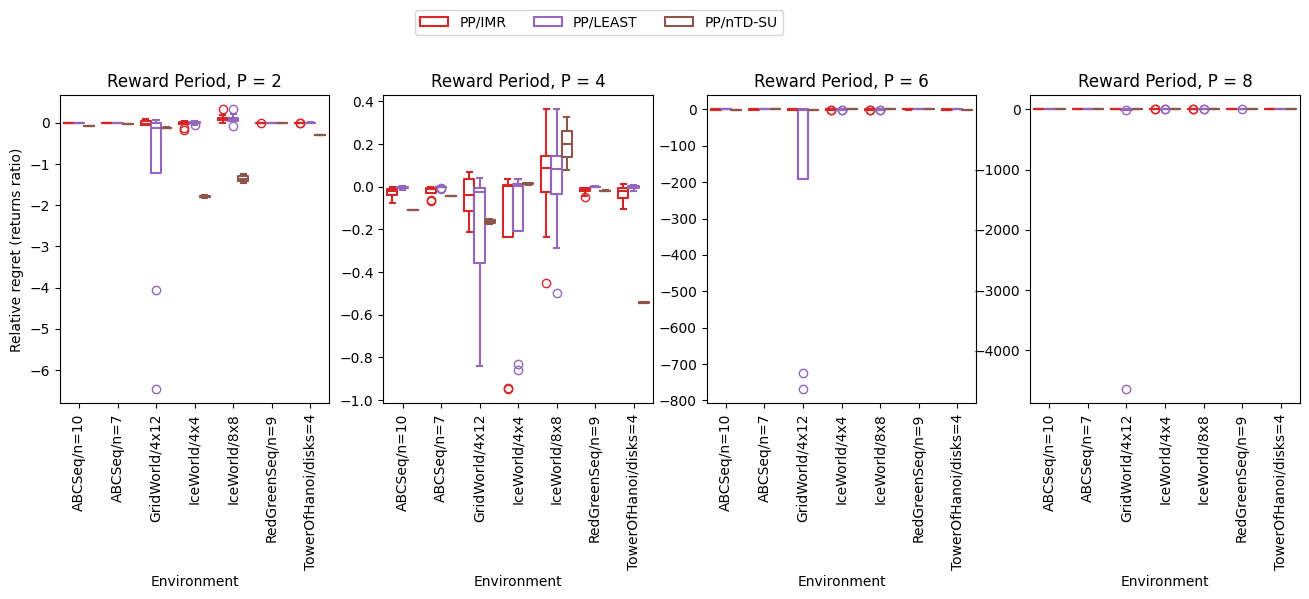

In [20]:
plot_regret(dfs_regret["n-step"], suffix="n-step_all")

## For Print

### Relative Regret - Returns Ratio

In [21]:
def print_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = df_data[["env", "reward_period", "method", "relative_regret"]]
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]    
    rps = df_raw["reward_period"].unique()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["reward_period"] == rp]        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
        sns.boxplot(
            df_plot, 
            x="env", y="relative_regret", 
            hue="method",
            palette=PALETTES,
            ax=ax,
            fill=False
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Relative regret (returns ratio)")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

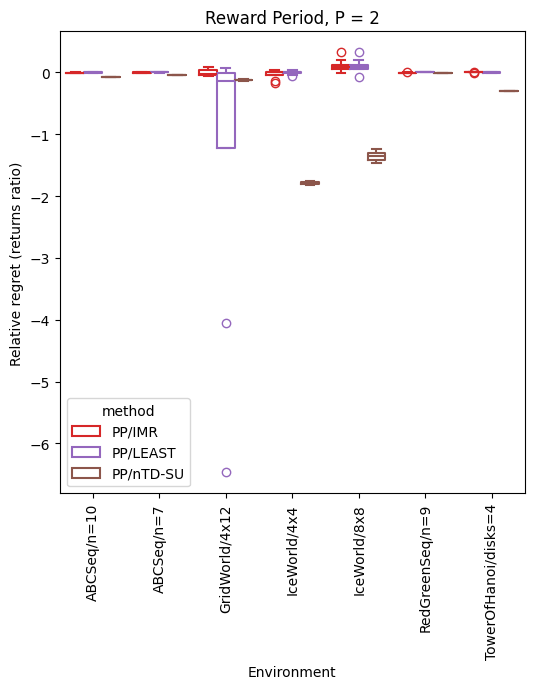

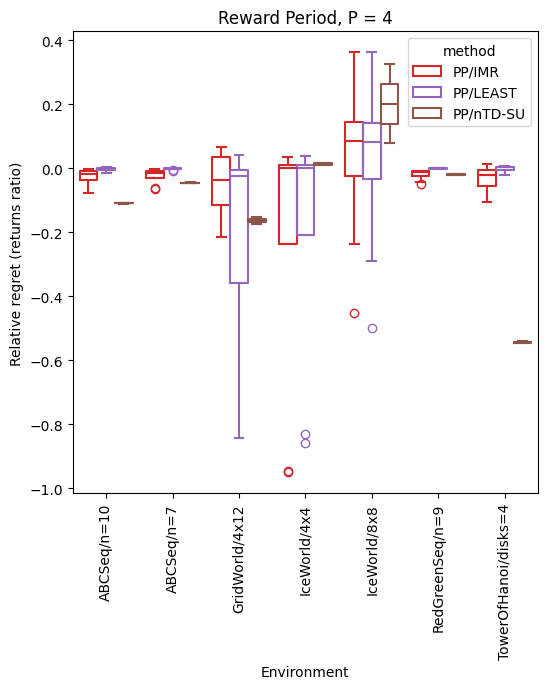

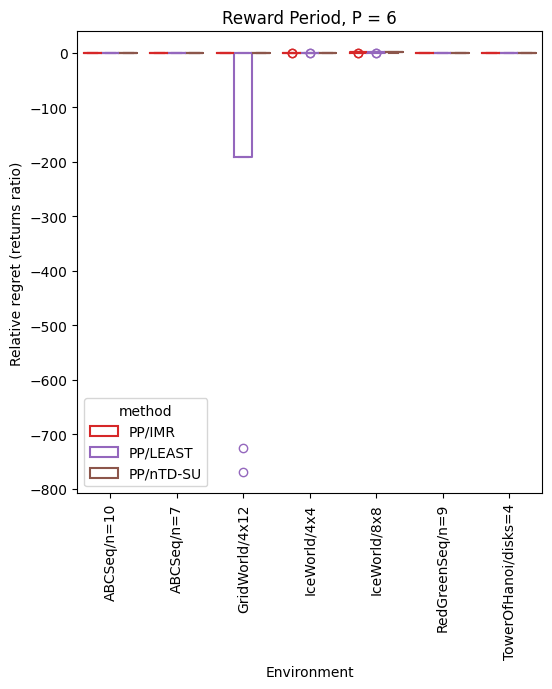

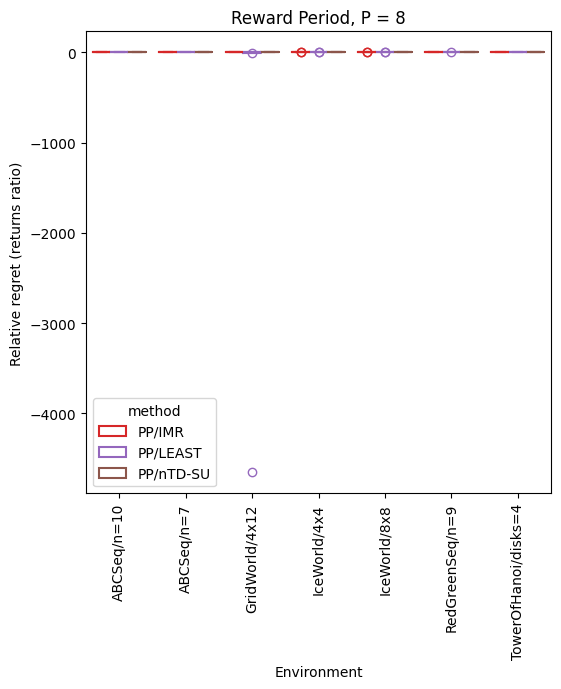

In [22]:
print_regret(dfs_regret["n-step"], suffix="n-step_all")

### Regret per Env

In [23]:
def plot_regret_dist(df_data, suffix, output_dir="figures/regret"):
    names = sorted(df_data["env"].unique())
    for name in names:
        env, args = name.split("/")
        df_slice = df_data[df_data["env"] == name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice, 
            x="relative_regret", 
            hue="method", 
            palette=PALETTES,
            fill=False,
            ax=ax
        )
        ax.set_xlabel("Relative regret (returns ratio)")
        ax.set_ylabel("Density")
        ax.set_title(f"Environment = {name}")
        name = f"regret_{suffix}_env_{env}_{args}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

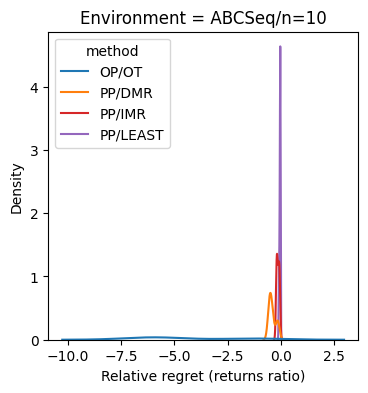

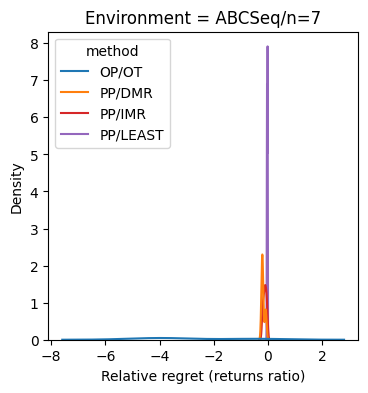

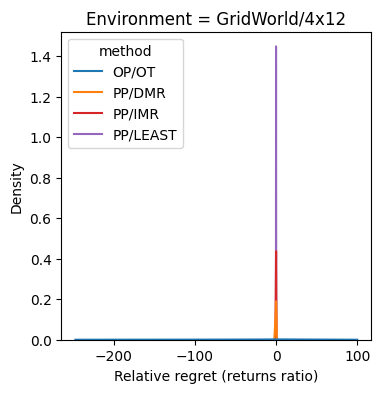

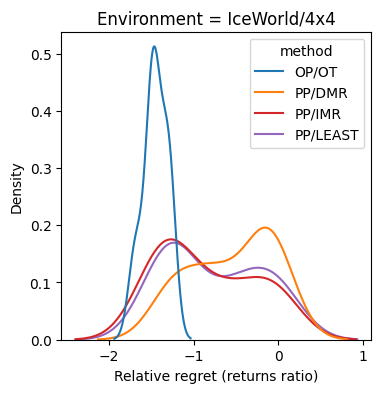

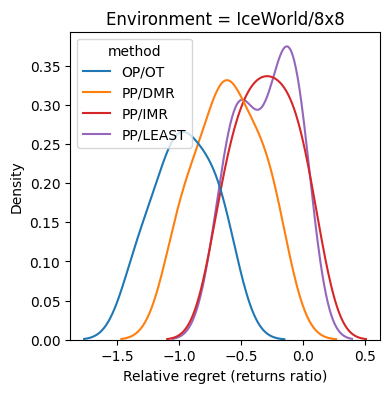

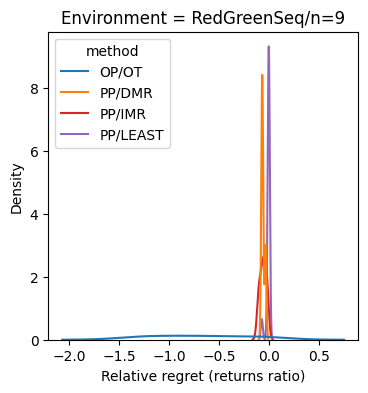

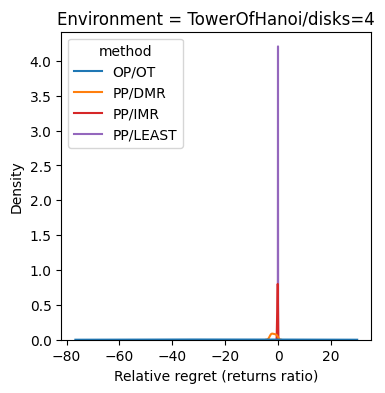

In [24]:
plot_regret_dist(dfs_regret["one-step"][dfs_regret["one-step"]["reward_period"] < 16], "one-step")

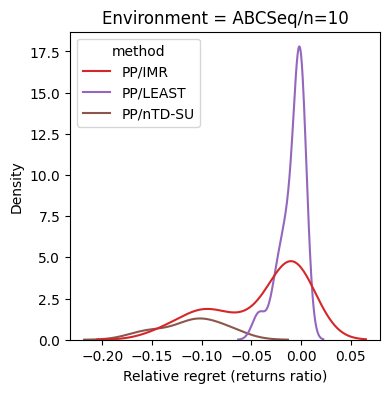

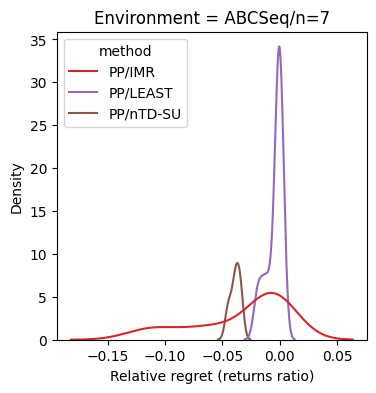

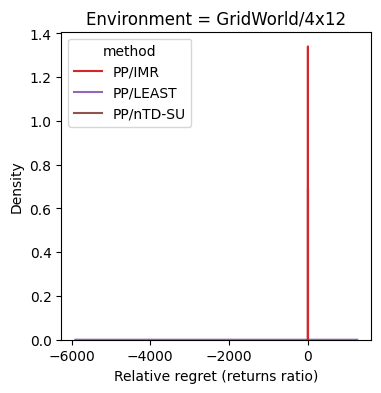

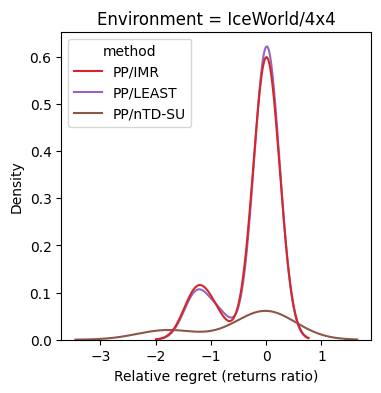

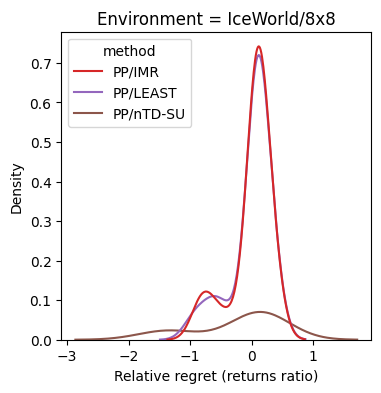

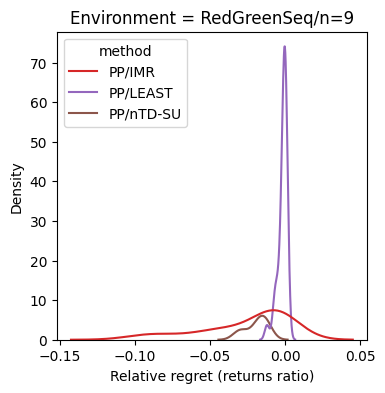

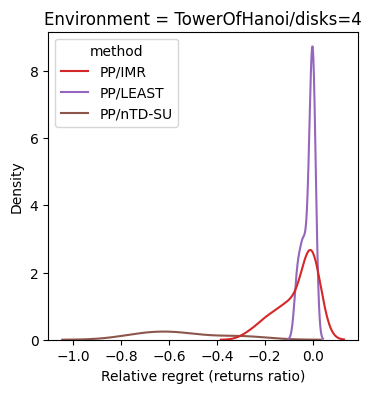

In [25]:
plot_regret_dist(dfs_regret["n-step"], "n-step")